(Feature_importance_-_explainability_in_one_line)=
# Feature importance - explainability in one line

The goal of this notebook is to ''open the box'' at (nearly) no cost. As we mainly focus on two types of models (decision-tree based algorithms and neural networks), two one-line sklearn commands can be used, one for each type of model. 

In both cases, the underlying idea, allowing the explanation, is discussed. The two methods discussed are the following:

1. The Gini feature importance, which is model-specific. It allows ranking the importance of features for tree-based classifiers.  
2. The feature permutation importance, which is model-agnostic. This method also provides a ranking of the importance of the features but it can be applied to any model. 

## The Gini feature importance

Recall how decision trees are built: every non-terminal node has a split value for a single feature. The split values and corresponding features are chosen, such as the two obtained children nodes are purer (i.e., the two target classes are more segregated) after the split. For classification problems (such as in fraud detection), this purity is usually measured by
- the Gini criterion (which is used by default in sklearn),
- or the information gain.

The Gini feature importance measure is, for each feature, the total reduction of the Gini criterion. This total reduction is normalized per node size. Therefore, the Gini feature importance is sometimes called MDI for mean decrease impurity. For random forests, it reports the average of the impurity decreases over all trees. 

This explanation method is model-specific, as it relies on the Gini impurity mechanism of the trees.

![or-clf](img/or-clf.png)


Through this lesson, some explanations for models trained will be provided by multiple explainers. To assess these explanations, we need to compare them to a sort of ground truth explanation. 

During the lesson, we will use a toy example. We dispose of transactional data. Our goal is to make (and explain) a model that predicts whether or not a transaction is a fraudulent one.

From the data exploration, we observe two scenarios:

- Scenario 1: All transactions with an amount higher than 220 seem to be flagged as fraudulent. Clearly, the amount is expected to be part of the explanation, and 220 is an important threshold.
- Scenario 2: By monitoring the average amount of transactions on a given time window, we've noticed that for compromised customers, 1/3 of their transactions have their amounts multiplied by 5, i.e. some transactions involve an amount that is much larger than the "usual" transactions of the customer.

In order to discuss the merit of each explanation method, a model is trained on a week of transactional data. 

`TX_AMOUNT`, `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW`, and `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` are included as interesting features, and `TX_DURING_NIGHT` is also included, representing a non predictive feature. Two types of models are considered: random forests and neural networks.

Before computing feature importances, we need a model. We train a default random forest:

In [6]:
# pip install the required libraries.

# ! pip install graphviz
# ! pip install xgboost
# ! pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [7]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   545k      0 --:--:-- --:--:-- --:--:--  546k


In [10]:
import numpy as np
import pandas as pd
import timeit
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

%run shared_functions.py

# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-09-26"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
end_date_training = datetime.datetime.strptime("2018-07-31", "%Y-%m-%d")

# Delay period
start_date_delay = datetime.datetime.strptime("2018-08-01", "%Y-%m-%d")
end_date_delay = datetime.datetime.strptime("2018-08-07", "%Y-%m-%d")

# Test period
start_date_test = datetime.datetime.strptime("2018-08-08", "%Y-%m-%d")
end_date_test = datetime.datetime.strptime("2018-08-15", "%Y-%m-%d")

# Get the corresponding data
train = transactions_df[transactions_df.TX_DATETIME<end_date_training]
delay = transactions_df[transactions_df.TX_DATETIME>start_date_delay]
delay =           delay[transactions_df.TX_DATETIME<end_date_delay] 
test = transactions_df[transactions_df.TX_DATETIME>start_date_test]

# Build classifier
clf = RandomForestClassifier(random_state=0)

input_features = ['TX_AMOUNT', 'TX_DURING_NIGHT', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW']
input_features_small = ['AMOUNT', 'NIGHT', 'AVA1D', 'AVA30D']
output_feature = "TX_FRAUD"

# Train classifier
model_and_predictions_dictionary = fit_model_and_get_predictions(clf, train, test, 
                                                                 input_features, output_feature, scale=False)

test['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(test, top_k_list=[50])

Load  files
CPU times: user 169 ms, sys: 189 ms, total: 358 ms
Wall time: 1.37 s
613550 transactions loaded, containing 5500 fraudulent transactions


,AUC ROC,Average precision,Card Precision@50
0,0.665,0.303,0.154


As promised in the name of this section, the Gini feature importance is fast to compute and easy to retrieve, in a single line:

In [11]:
pd.Series(clf.feature_importances_,index=input_features)

TX_AMOUNT                              0.401686
TX_DURING_NIGHT                        0.007298
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW     0.284104
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW    0.306912
dtype: float64

`TX_AMOUNT` appears to be the most important feature, which is unsurprising, regarding its key role in fraud scenario 1. The `AVG_AMOUNT` features are also important, as they allow to detect the fraud scenario 2. The Gini importance fails to decide which one is the most important, however. Finally, `TX_DURING_NIGHT` is not important, as it is expected from a noisy feature.

For random forests, sklearn proposes the following code snippet to display the MDI (Mean Decrease Impurity) for all trees in a plot. The importance is just the average among all trees, with the associated variances appearing as black bars.

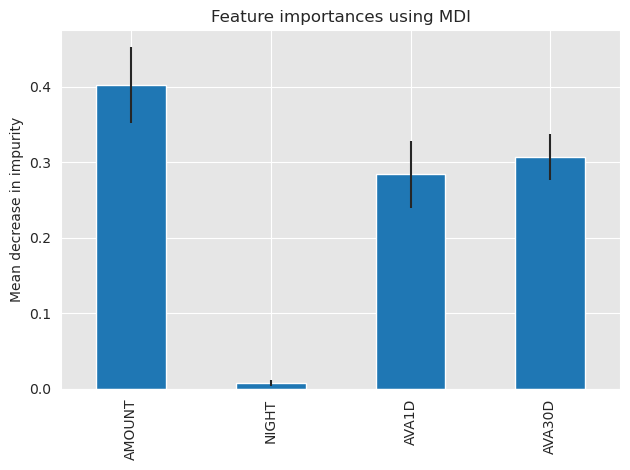

In [12]:
# Compute the feature importance and their standard deviations
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=input_features_small)

# Plot the feature importance and standard deviations
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The Gini feature importance is known to be biased in favor of features with high cardinality. So it must be used cautiously. We can be confident in our findings as there were no such features here.

https://explained.ai/rf-importance/index.html
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25

Therefore the use of this technique is in some cases discouraged, and it is encouraged to use the feature permutation technique instead (or maybe even the "drop-feature" method).

## The feature permutation importance

Of course, the Gini feature importance is specific to tree-based algorithms and cannot be used for neural networks. Therefore, another popular approach is introduced: the feature permutation importance. 

The feature permutation of a given feature is computed as the difference between a baseline score $s$ and the average score obtained by randomly permuting the corresponding feature column: 

$$ f_j = s - \frac{1}{n} \displaystyle \sum_{i=1}^n s_{ij}$$

where $j$ is the feature under consideration and $i$ controls the repetitions (see below). The score can be any accuracy measure for classification or $R^2$ for regression. If $f_j$ is small, then the model is insensitive to permutations of feature $j$, and it implies that the importance of $j$ is low. Contrarily, if $f_j$ is large, then the importance of feature $j$ is high. Usually, multiple permutations per feature are computed and averaged. This is the role of the variable $n$ (which is five by default in sklearn). More permutations allow a better estimation of the feature importance, but computation time also increases. 

For exaple, permuting the TX_AMOUNT column would look like this:

![les9_permutation_based_feature_importance](img/les9_permutation_based_feature_importance.png)

Let us now train a default sklearn neural network and obtain the feature permutation importance for it.

In [6]:
clf = MLPClassifier(random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(clf, train, test, 
                                                                 input_features, output_feature, scale=False)

test['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(test, top_k_list=[50])

,AUC ROC,Average precision,Card Precision@50
0,0.66,0.292,0.147


The code for the permutation importance is also really convenient (but is is slower to compute than the Gini importance):

In [7]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, test[input_features], test[output_feature], random_state=0)

In [8]:
pd.Series(result.importances_mean, index=input_features)

TX_AMOUNT                              0.136433
TX_DURING_NIGHT                       -0.000008
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW     0.000224
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW    0.144310
dtype: float64

Here, the results are a bit different than with the random forest, but with some similarities. `TX_AMOUNT` is still the most important feature, but `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` is almost equally important. The other `AVG_AMOUNT` features are less important. `TX_DURING_NIGHT` is still not important, as expected.